# Modeling and Simulation in Python

Chapter 13

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from previous chapters

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [39]:
def make_system(beta, gamma, t_end):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [40]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', label='Susceptible')
    plot(I, '-', label='Infected')
    plot(R, ':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [41]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

Here's an updated version of `run_simulation` that uses `unpack`.

In [42]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

**Exercise:** Write a version of `update_func` that uses `unpack`.

In [43]:
# Original

def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [44]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i, r = state

    infected = beta * i * s    
    recovered = gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

Test the updated code with this example.

In [45]:
system = make_system(0.333, 0.25)
results = run_simulation(system, update_func)
results.head()

TypeError: make_system() missing 1 required positional argument: 't_end'

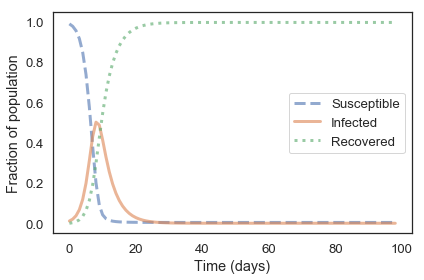

In [46]:
plot_results(results.S, results.I, results.R)

### Sweeping beta

Make a range of values for `beta`, with constant `gamma`.

In [47]:
beta_array = linspace(0.1, 1.1, 11)
gamma = 0.25

0.25

Run the simulation once for each value of `beta` and print total infections.

In [48]:
for beta in beta_array:
    system = make_system(beta, gamma)
    results = run_simulation(system, update_func)
    print(system.beta, calc_total_infected(results))

TypeError: make_system() missing 1 required positional argument: 't_end'

Wrap that loop in a function and return a `SweepSeries` object.

In [49]:
def sweep_beta(beta_array, gamma):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[system.beta] = calc_total_infected(results)
    return sweep

Sweep `beta` and plot the results.

In [50]:
infected_sweep = sweep_beta(beta_array, gamma)

TypeError: make_system() missing 1 required positional argument: 't_end'

Saving figure to file figs/chap06-fig01.pdf


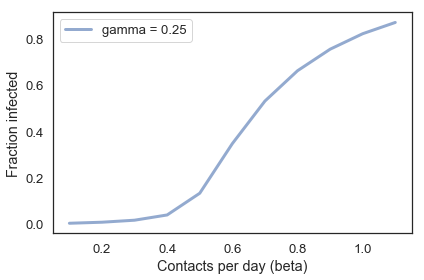

In [51]:
label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)

decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')

savefig('figs/chap06-fig01.pdf')

### Sweeping gamma

Using the same array of values for `beta`

In [52]:
beta_array

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])

And now an array of values for `gamma`

In [53]:
gamma_array = [0.2, 0.4, 0.6, 0.8]

[0.2, 0.4, 0.6, 0.8]

For each value of `gamma`, sweep `beta` and plot the results.

In [54]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'γ = ' + str(gamma)
    plot(infected_sweep, label=label)
    
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected',
         loc='upper left')

savefig('figs/chap06-fig02.pdf')

TypeError: make_system() missing 1 required positional argument: 't_end'

** Exercise:**  Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point.  Estimate the time between contacts.

In [55]:
gamma = .5
infected_sweep = sweep_beta(beta_array, gamma)
plot(infected_sweep)
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')
series = SweepSeries()
linrange1 = linspace(0,1,11)
for i in linrange1:
    series[i] = 0.4
plot(series)

TypeError: make_system() missing 1 required positional argument: 't_end'

In [56]:
# Roughly 0.6 contacts per day
contact = 0.6
hoursBetween = (1/contact)*24
print(hoursBetween)

40.0


# Slope Function and ODE Solver

In [68]:
def slope_func(state, t0, system):
    unpack(system)
    s, i, r = state

    sus = -beta * i * s   
    infected = beta * i * s - gamma * i
    recovered = gamma * i
    
    return sus, infected, recovered

(-0.003658888888888889, 0.0008811111111111112, 0.002777777777777778)
                   S         I         R
0.000000    0.988889  0.011111  0.000000
0.090979    0.988555  0.011192  0.000254
1.000773    0.985086  0.012021  0.002893
3.000773    0.976595  0.014013  0.009392
5.000773    0.966820  0.016236  0.016944
7.000773    0.955655  0.018681  0.025664
9.000773    0.943018  0.021324  0.035658
11.000773   0.928860  0.024125  0.047015
13.000773   0.913177  0.027024  0.059799
15.000773   0.896016  0.029942  0.074042
17.000773   0.877488  0.032783  0.089729
19.000773   0.857766  0.035439  0.106795
21.000773   0.837084  0.037798  0.125118
23.000773   0.815723  0.039752  0.144525
25.000773   0.794001  0.041211  0.164788
27.000773   0.772248  0.042109  0.185642
29.000773   0.750791  0.042411  0.206798
31.000773   0.729929  0.042117  0.227954
33.000773   0.709921  0.041259  0.248820
35.000773   0.690974  0.039897  0.269129
37.000773   0.673242  0.038111  0.288647
39.000773   0.656821  0.03599

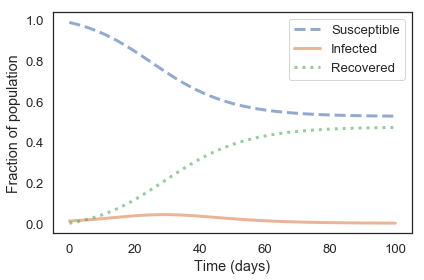

In [75]:
system = make_system(0.333, 0.25, 100)
test = slope_func(system.init, 0, system)
print(test)
results, details = run_ode_solver(system, slope_func, max_step = 2)
print(results)
plot_results(results.S, results.I, results.R)